<a href="https://colab.research.google.com/github/RDLL/curso_ia/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación KNN

## Tarea 2

## Detección de insuficencia cardiaca

In [86]:
# Tratamiento de datos
#=========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from math import sqrt

plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

# Preprocesado
#=========================================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [1]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/RDLL/curso_ia/main/heart.csv")
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [4]:
def faltantes(data):
  ft = data.isnull().sum(min_count=1)
  ft = ft[ft != 0].to_dict()
  return ft

In [5]:
vfal = faltantes(df)
print(vfal)
porcentajes = vfal
for clave in vfal:
  porcentajes[clave] = (vfal[clave]/df.shape[0]) * 100
print(porcentajes)

{}
{}


In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


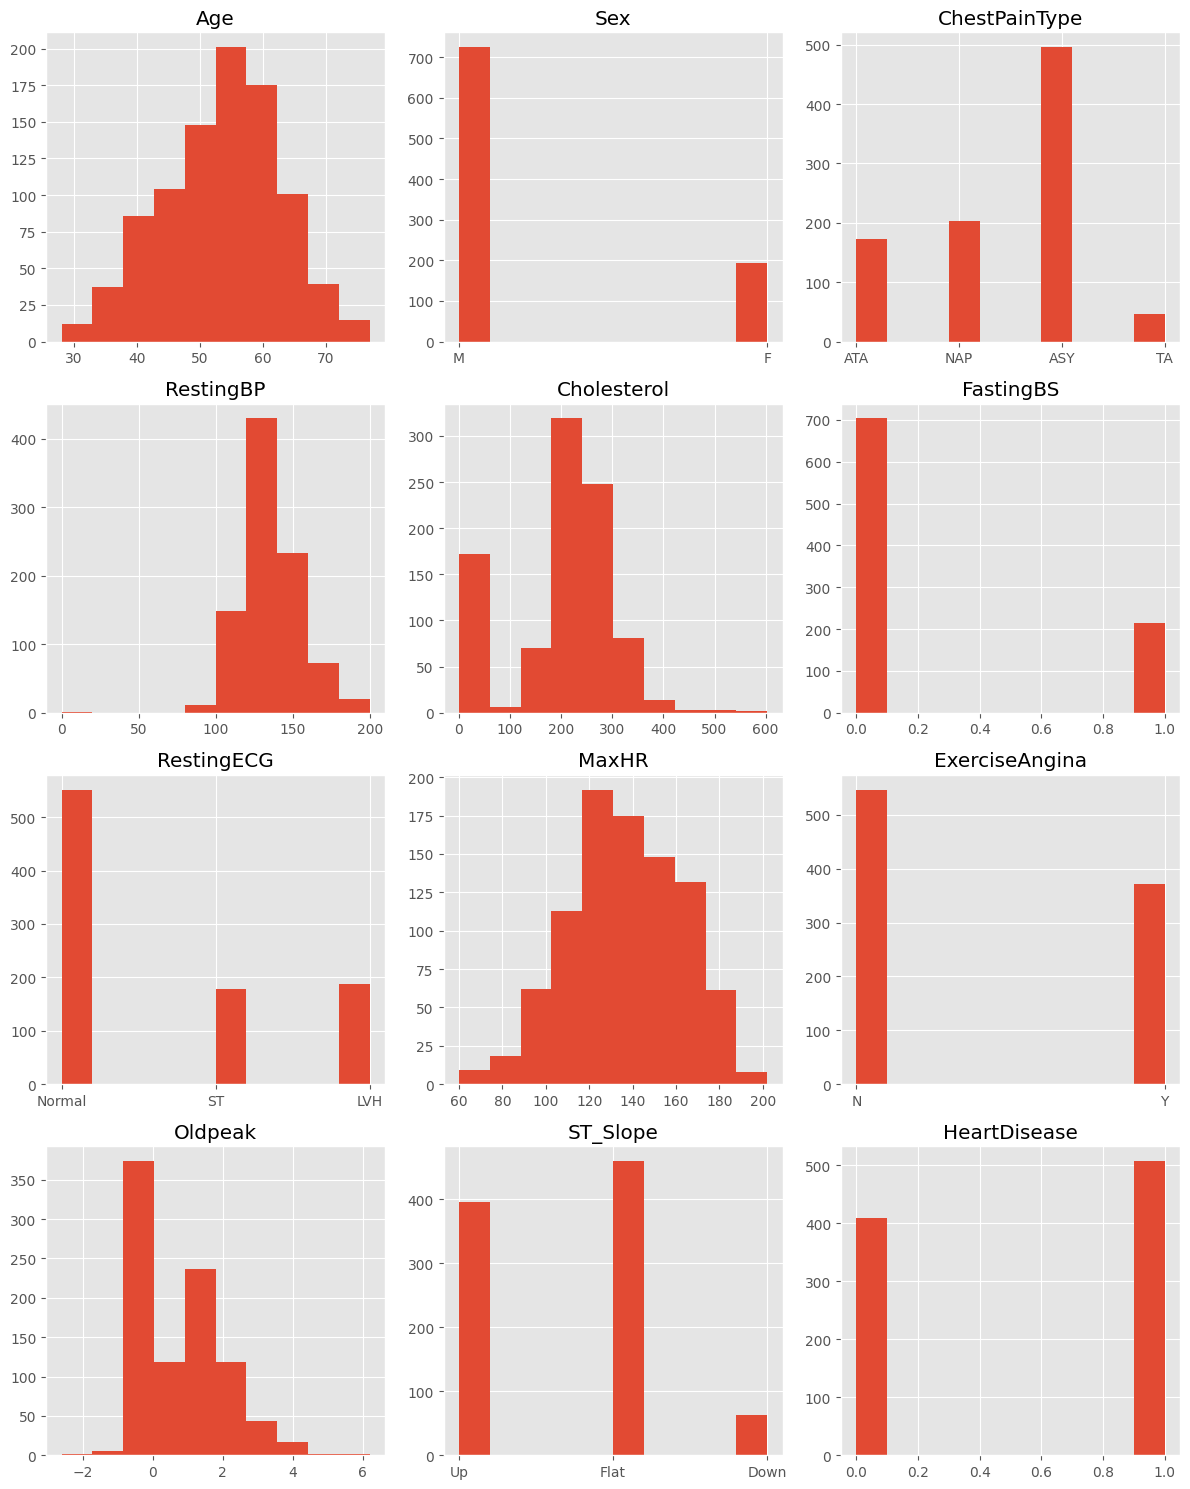

In [7]:
viz_df = df.copy()
k = 0
plt.figure(figsize=(12,15))
for col in viz_df.columns:
  plt.subplot(4,3,k+1)
  plt.hist(viz_df[col])
  plt.title(f"{col}")
  k+=1
plt.tight_layout()

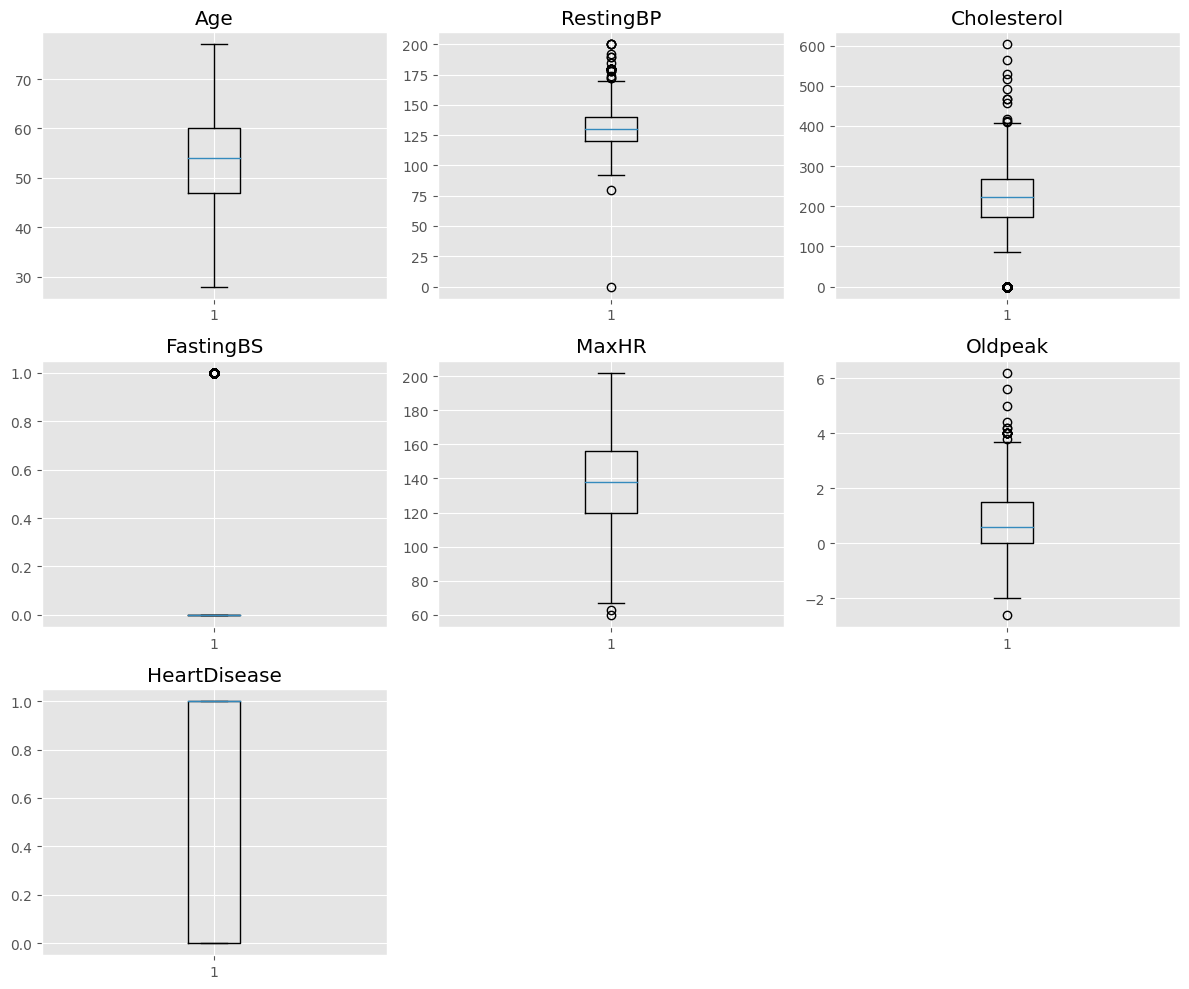

In [8]:
viz_df = df.select_dtypes(include = np.number)
k = 0
plt.figure(figsize=(12,10))
for col in viz_df.columns:
  plt.subplot(3,3,k+1)
  plt.boxplot(viz_df[col])
  plt.title(f"{col}")
  k+=1
plt.tight_layout()

In [9]:
encoder = OrdinalEncoder()
df[['Sex','ExerciseAngina']] = encoder.fit_transform(df[['Sex','ExerciseAngina']])
df[['Sex','ExerciseAngina']].head()

,Sex,ExerciseAngina
0,1,1
1,2,1
2,1,1
3,2,2
4,1,1


In [10]:
def codificar(col,cols):
  column = col
  print(col, type(col))
  codificador = OneHotEncoder()
  codificacion = codificador.fit_transform(df[column])
  nuevas_cols = pd.DataFrame(codificacion.toarray(),columns=codificador.categories_)
  nuevas_cols.columns = cols
  return nuevas_cols

In [11]:
df= pd.concat([df, codificar(['ChestPainType'],['ASY','ATA','NAP','TA'])], axis="columns")
df= pd.concat([df, codificar(['RestingECG'],['LVH','Normal','ST'])], axis="columns")
df= pd.concat([df, codificar(['ST_Slope'],['Down','Flat','Up'  ])], axis="columns")

['ChestPainType'] <class 'list'>
['RestingECG'] <class 'list'>
['ST_Slope'] <class 'list'>


In [12]:
categoricas = ('Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope')
for i in categoricas:
  print("Categorias de ",i,":",df[i].unique())

Categorias de  Sex : [1 2]
Categorias de  ChestPainType : ['ATA' 'NAP' 'ASY' 'TA']
Categorias de  RestingECG : ['Normal' 'ST' 'LVH']
Categorias de  ExerciseAngina : [1 2]
Categorias de  ST_Slope : ['Up' 'Flat' 'Down']


In [13]:
df = df.drop(['ChestPainType'],axis=1)
df = df.drop(['RestingECG'],axis=1)
df = df.drop(['ST_Slope'],axis=1)

In [32]:
corr_matrix = df.corr()
corr_matrix

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ASY,ATA,NAP,TA,LVH,Normal,ST,Down,Flat,Up
Age,1.000000,-0.055750,0.254399,-0.095282,0.198039,-0.382045,0.215793,0.258612,0.282039,0.166607,-0.218165,-0.011335,0.032042,0.145727,-0.230566,0.136798,0.138397,0.185568,-0.258067
Sex,-0.055750,1.000000,-0.005133,0.200092,-0.120076,0.189186,-0.190664,-0.105734,-0.305445,-0.183876,0.161522,0.066486,0.004031,0.049518,0.010634,-0.063715,-0.066036,-0.116077,0.150942
RestingBP,0.254399,-0.005133,1.000000,0.100893,0.070193,-0.112135,0.155101,0.164803,0.107589,0.048824,-0.046153,-0.041348,0.049855,0.053166,-0.116851,0.090447,-0.007912,0.099207,-0.096146
Cholesterol,-0.095282,0.200092,0.100893,1.000000,-0.260974,0.235792,-0.034166,0.050148,-0.232741,-0.120531,0.150954,-0.006634,0.017365,0.177077,-0.038470,-0.133106,-0.083371,-0.050953,0.094027
FastingBS,0.198039,-0.120076,0.070193,-0.260974,1.000000,-0.131438,0.060451,0.052698,0.267291,0.131176,-0.140514,-0.039249,0.026885,-0.011656,-0.093028,0.127110,0.105102,0.107006,-0.161730
MaxHR,-0.382045,0.189186,-0.112135,0.235792,-0.131438,1.000000,-0.370425,-0.160691,-0.400421,-0.354963,0.253735,0.134580,0.100025,0.125793,0.023801,-0.157879,-0.073316,-0.342581,0.383397
ExerciseAngina,0.215793,-0.190664,0.155101,-0.034166,0.060451,-0.370425,1.000000,0.408752,0.494282,0.430034,-0.300365,-0.166030,-0.128105,-0.016382,-0.072924,0.107036,0.136439,0.382237,-0.455676
Oldpeak,0.258612,-0.105734,0.164803,0.050148,0.052698,-0.160691,0.408752,1.000000,0.403951,0.280026,-0.262124,-0.106212,0.032231,0.086794,-0.116719,0.055958,0.322130,0.283295,-0.450577
HeartDisease,0.282039,-0.305445,0.107589,-0.232741,0.267291,-0.400421,0.494282,0.403951,1.000000,0.516716,-0.401924,-0.212964,-0.054790,0.010670,-0.091580,0.102527,0.122527,0.554134,-0.622164
ASY,0.166607,-0.183876,0.048824,-0.120531,0.131176,-0.354963,0.430034,0.280026,0.516716,1.000000,-0.522432,-0.577670,-0.249003,0.002289,-0.063606,0.076438,0.103407,0.303645,-0.359443


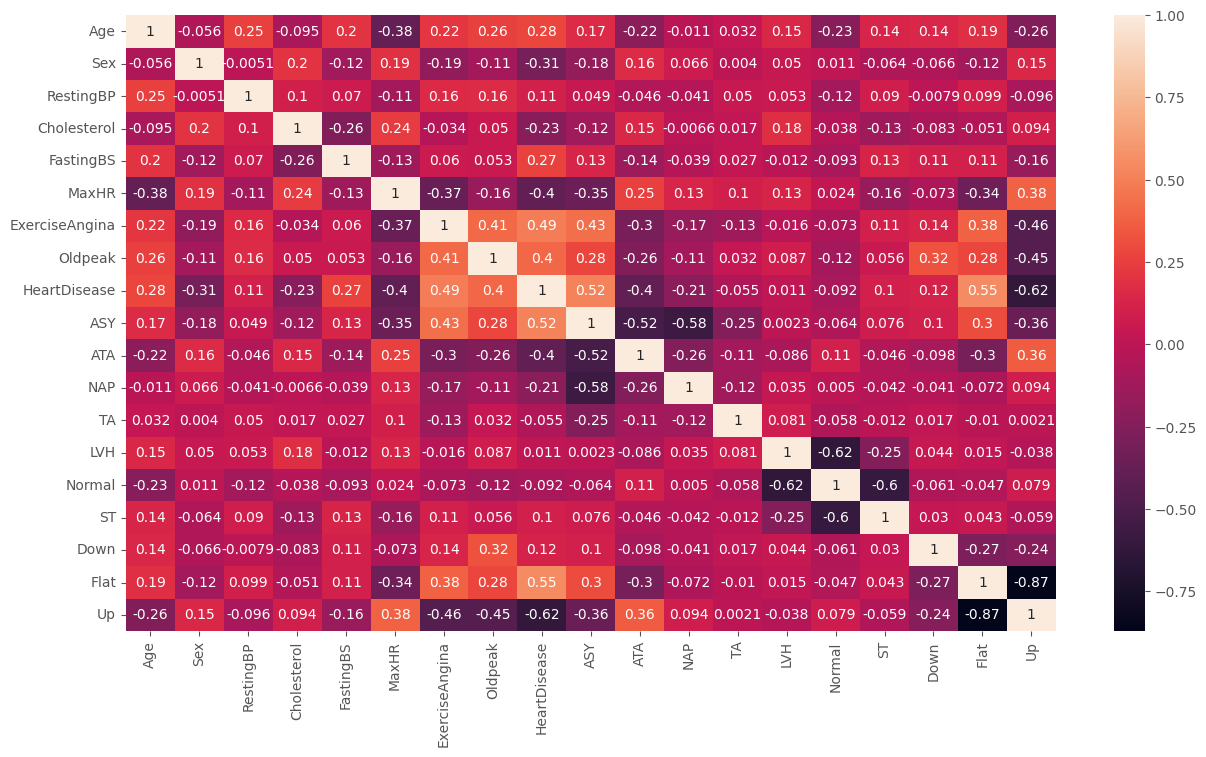

In [33]:
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [16]:
def tidy_corr_mat(corr_mat):
  corr_mat = corr_mat.stack().reset_index()
  corr_mat.columns = ['variable_1','variable_2','r']
  corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'],:]
  corr_mat['abs_r'] = np.abs(corr_mat['r'])
  corr_mat = corr_mat.sort_values('abs_r',ascending=False)
  return corr_mat

tidy_corr_mat(corr_matrix)

,variable_1,variable_2,r,abs_r
359,Up,Flat,-0.870951,0.870951
341,Flat,Up,-0.870951,0.870951
279,Normal,LVH,-0.623227,0.623227
261,LVH,Normal,-0.623227,0.623227
350,Up,HeartDisease,-0.622164,0.622164
...,...,...,...,...
229,TA,Sex,0.004031,0.004031
184,ASY,LVH,0.002289,0.002289
256,LVH,ASY,0.002289,0.002289
354,Up,TA,0.002087,0.002087


In [67]:
X = df[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ASY', 'ATA', 'NAP', 'TA',
       'LVH', 'Normal', 'ST', 'Down', 'Flat', 'Up']].values
Y = df['HeartDisease'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [18]:
preprocessor = Pipeline(
    [
      ("scaler",MinMaxScaler()),
      ("pca",PCA(n_components = 18,random_state=42))
    ]
)

In [19]:
pipe = Pipeline([("preprocessor",preprocessor)])

In [20]:
X_train = pipe["preprocessor"]["scaler"].fit_transform(X_train)
X_test = pipe["preprocessor"]["scaler"].transform(X_test)

In [21]:
pipe.fit(X_train)
print("Datos de entrenamiento con 18 componentes\n")
print(pipe["preprocessor"]["pca"].explained_variance_,'\n')
print(pipe["preprocessor"]["pca"].explained_variance_ratio_)

pipe["preprocessor"]["pca"] .n_components = 12
print("\nDatos de entrenamiento con 12 componentes\n")
pipe.fit(X_train)
print(pipe["preprocessor"]["pca"].explained_variance_,'\n')
print(pipe["preprocessor"]["pca"].explained_variance_ratio_)

Datos de entrenamiento con 18 componentes

[6.79579455e-01 3.64873608e-01 2.85879401e-01 2.13982485e-01
 1.90122914e-01 1.73139001e-01 1.54732876e-01 1.38526288e-01
 9.36336420e-02 6.83329582e-02 3.76875520e-02 3.16179621e-02
 2.14095437e-02 1.73309128e-02 9.33643887e-03 3.70380955e-32
 1.96946571e-32 1.76218376e-32] 

[2.74003530e-01 1.47115478e-01 1.15265352e-01 8.62768227e-02
 7.66567458e-02 6.98089049e-02 6.23876338e-02 5.58532068e-02
 3.77526840e-02 2.75515565e-02 1.51954598e-02 1.27482271e-02
 8.63223644e-03 6.98774991e-03 3.76441223e-03 1.49336017e-32
 7.94080153e-33 7.10504958e-33]

Datos de entrenamiento con 12 componentes

[0.67957946 0.36487361 0.2858794  0.21398248 0.19012291 0.173139
 0.15473288 0.13852629 0.09363364 0.06833296 0.03768755 0.03161796] 

[0.27400353 0.14711548 0.11526535 0.08627682 0.07665675 0.0698089
 0.06238763 0.05585321 0.03775268 0.02755156 0.01519546 0.01274823]


In [22]:
pipe.fit(X_test)
print("Datos de prueba con 18 componentes\n")
print(pipe["preprocessor"]["pca"].explained_variance_,'\n')
print(pipe["preprocessor"]["pca"].explained_variance_ratio_)

print("\nDatos de prueba con 12 componentes\n")
pipe["preprocessor"]["pca"] .n_components = 12
pipe.fit(X_test)
print(pipe["preprocessor"]["pca"].explained_variance_,'\n')
print(pipe["preprocessor"]["pca"].explained_variance_ratio_)

Datos de prueba con 18 componentes

[0.76570391 0.35682916 0.27986991 0.24410689 0.20067084 0.14916914
 0.13315665 0.10774703 0.07423056 0.04898863 0.03424125 0.02208628] 

[0.31119595 0.14502184 0.1137442  0.09920947 0.08155627 0.06062504
 0.05411728 0.04379035 0.03016864 0.01990987 0.01391627 0.00897627]

Datos de prueba con 12 componentes

[0.76570391 0.35682916 0.27986991 0.24410689 0.20067084 0.14916914
 0.13315665 0.10774703 0.07423056 0.04898863 0.03424125 0.02208628] 

[0.31119595 0.14502184 0.1137442  0.09920947 0.08155627 0.06062504
 0.05411728 0.04379035 0.03016864 0.01990987 0.01391627 0.00897627]


In [50]:
parameters = {"n_neighbors": range(2, 50),"weights":('distance','uniform')}
grid = GridSearchCV (KNeighborsClassifier(), param_grid = parameters, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 50),
                         'weights': ('distance', 'uniform')})

In [41]:
grid.fit(X_train, y_train)
print("KNN Best Parameters: ", grid.best_params_)

model= grid.best_estimator_
print("KNN Best Score: ", grid.best_score_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('classification_report:\n',classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

print("Error cuadrático medio: ",  mean_squared_error(y_test,y_pred))

KNN Best Parameters:  {'n_neighbors': 47, 'weights': 'uniform'}
KNN Best Score:  0.8610194762836642
classification_report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88        86
           1       0.90      0.89      0.89        98

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Error cuadrático medio:  0.11413043478260869


In [60]:
n_neighbors = 47
knn = KNeighborsClassifier(n_neighbors,weights = 'uniform')
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.89


In [103]:
pipe["preprocessor"]["pca"].n_components = 2
pipe.fit(X_train)
pipe.fit(X_test)
X_train = pipe["preprocessor"]["scaler"].fit_transform(X_train)
X_test = pipe["preprocessor"]["scaler"].fit_transform(X_test)

In [104]:
knn = KNeighborsClassifier(n_neighbors, weights = 'uniform')
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=47)

In [105]:
train_preds = knn.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse
X = train_preds
Y = y_train